This section is just for experimentation, specifically to find the best values ​​for eps and min_pts using the iris dataset as the experimental dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Step 1: Load iris dataset
iris = fetch_ucirepo(id=53)  # ID 53 adalah Iris
X = iris.data.features.values[:, 2:]
true_labels = iris.data.targets.values.flatten()

In [3]:
# Step 2: Define Euclidean distance
def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

In [4]:
# Step 3: Cari tetangga dalam radius eps
def region_query(X, point_idx, eps):
    neighbors = []
    for i in range(len(X)):
        if euclidean(X[point_idx], X[i]) < eps:
            neighbors.append(i)
    return neighbors

In [5]:
# Step 4: Ekspansi cluster dari core point
def expand_cluster(X, labels, point_idx, cluster_id, eps, min_pts):
    neighbors = region_query(X, point_idx, eps)
    
    if len(neighbors) < min_pts:
        labels[point_idx] = -1  # noise
        return False
    else:
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if labels[neighbor_idx] == 0:
                labels[neighbor_idx] = cluster_id
                new_neighbors = region_query(X, neighbor_idx, eps)
                if len(new_neighbors) >= min_pts:
                    neighbors += new_neighbors
            elif labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            i += 1
        return True

In [6]:
# Step 5: DBSCAN utama
def dbscan(X, eps, min_pts):
    labels = [0] * len(X)  # 0 = belum dikunjungi
    cluster_id = 0
    
    for point_idx in range(len(X)):
        if labels[point_idx] == 0:
            if expand_cluster(X, labels, point_idx, cluster_id + 1, eps, min_pts):
                cluster_id += 1
    return np.array(labels)

In [7]:

# Step 6: Visualisasi hasil clustering
def plot_dbscan(X, labels, title="DBSCAN Clustering"):
    unique_labels = set(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    for k in unique_labels:
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        if k == -1:
            plt.scatter(xy[:, 0], xy[:, 1], c='k', label='Noise', marker='x')
        else:
            plt.scatter(xy[:, 0], xy[:, 1], label=f'Cluster {k}', cmap=colors(k))

    plt.xlabel("Petal Length")
    plt.ylabel("Petal Width")
    plt.legend()
    plt.title(title)
    plt.show()

In [8]:
# Step 7: Grid Search untuk cari eps dan min_pts terbaik
eps_values = np.arange(0.1, 1.0, 0.05)
min_pts_values = range(2, 10)

best_ari = -1
best_silhouette = -1
best_params_ari = (None, None)
best_params_sil = (None, None)

for eps in eps_values:
    for min_pts in min_pts_values:
        labels = dbscan(X, eps, min_pts)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters > 1:
            ari = adjusted_rand_score(true_labels, labels)
            sil = silhouette_score(X, labels)

            if ari > best_ari:
                best_ari = ari
                best_params_ari = (eps, min_pts)
            
            if sil > best_silhouette:
                best_silhouette = sil
                best_params_sil = (eps, min_pts)

In [9]:
# Step 8: Tampilkan hasil terbaik berdasarkan ARI
print("=== Hasil Grid Search ===")
print(f"Best ARI: {best_ari:.4f} with eps={best_params_ari[0]:.2f}, min_pts={best_params_ari[1]}")
print(f"Best Silhouette Score: {best_silhouette:.4f} with eps={best_params_sil[0]:.2f}, min_pts={best_params_sil[1]}")

=== Hasil Grid Search ===
Best ARI: 0.6948 with eps=0.20, min_pts=8
Best Silhouette Score: 0.7667 with eps=0.35, min_pts=2


C:\Users\User\AppData\Local\Temp\ipykernel_27188\1186940875.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))
C:\Users\User\AppData\Local\Temp\ipykernel_27188\1186940875.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xy[:, 0], xy[:, 1], label=f'Cluster {k}', cmap=colors(k))


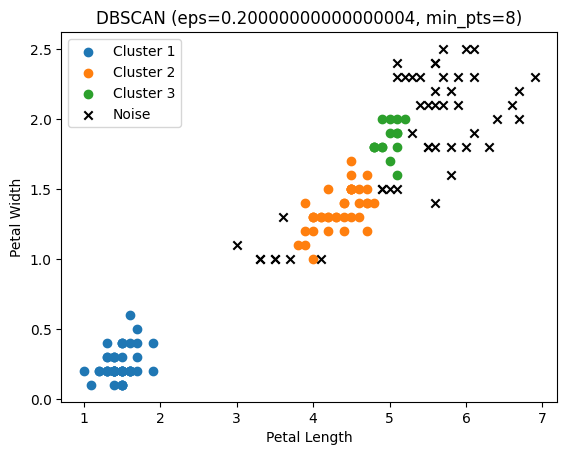

ARI (Best Params): 0.6948
Silhouette Score (Best Params): 0.4226


In [10]:
# Step 9: Visualisasi dan evaluasi akhir dengan parameter terbaik (berdasarkan ARI)
best_eps, best_min_pts = best_params_ari
final_labels = dbscan(X, best_eps, best_min_pts)

plot_dbscan(X, final_labels, title=f"DBSCAN (eps={best_eps}, min_pts={best_min_pts})")

ari = adjusted_rand_score(true_labels, final_labels)
print(f"ARI (Best Params): {ari:.4f}")
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)
if n_clusters > 1:
    sil_score = silhouette_score(X, final_labels)
    print(f"Silhouette Score (Best Params): {sil_score:.4f}")
else:
    print("Silhouette Score tidak bisa dihitung (cluster terlalu sedikit).")